In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from Oligo_pipeline import OligoPipeline

## Load batch that needs to be analysed

In [3]:

# Load the batch that needs to be analysed
file = 'Datasets/batch_3.csv'
data_batch = pd.read_csv(file)

# # Normalize by creatinine
data_batch = data_batch.assign(sample_amt_normalized = data_batch['sample_amt'] / data_batch['creatinine_mmol_liter'])

## Load batches that function as reference batches

In [4]:
# paths to reference batches
files = []
for i in range(1,4):
    files.append( 'Datasets/batch_{}.csv'.format(i))

all_data = pd.DataFrame([])
for file in files:
    df = pd.read_csv(file)

    # Normalize by creatinine
    df = df.assign(sample_amt_normalized = df['sample_amt'] / df['creatinine_mmol_liter'])
    df = df.assign(batch_name = file )
    
    # In an existing pipeline one could give other labels here to each sample. For example. known patients with a diagnosis could be stated in the column 'group'
    # samples that ar not a 'control' are not used as reference samples
    df = df.assign(group = 'control' )
    
    # OLIGO samples are postive control samples. In this example pipeline we use the postive controls also as reference
#     df.loc[df['sample_ID'].str.contains('OLIGO')] = df.loc[df['sample_ID'].str.contains('OLIGO')].assign(group = 'positive_control')

    
    all_data = pd.concat([all_data, df])

In [5]:
OP = OligoPipeline(data_batch, all_data)

## Determine reference values for each compound

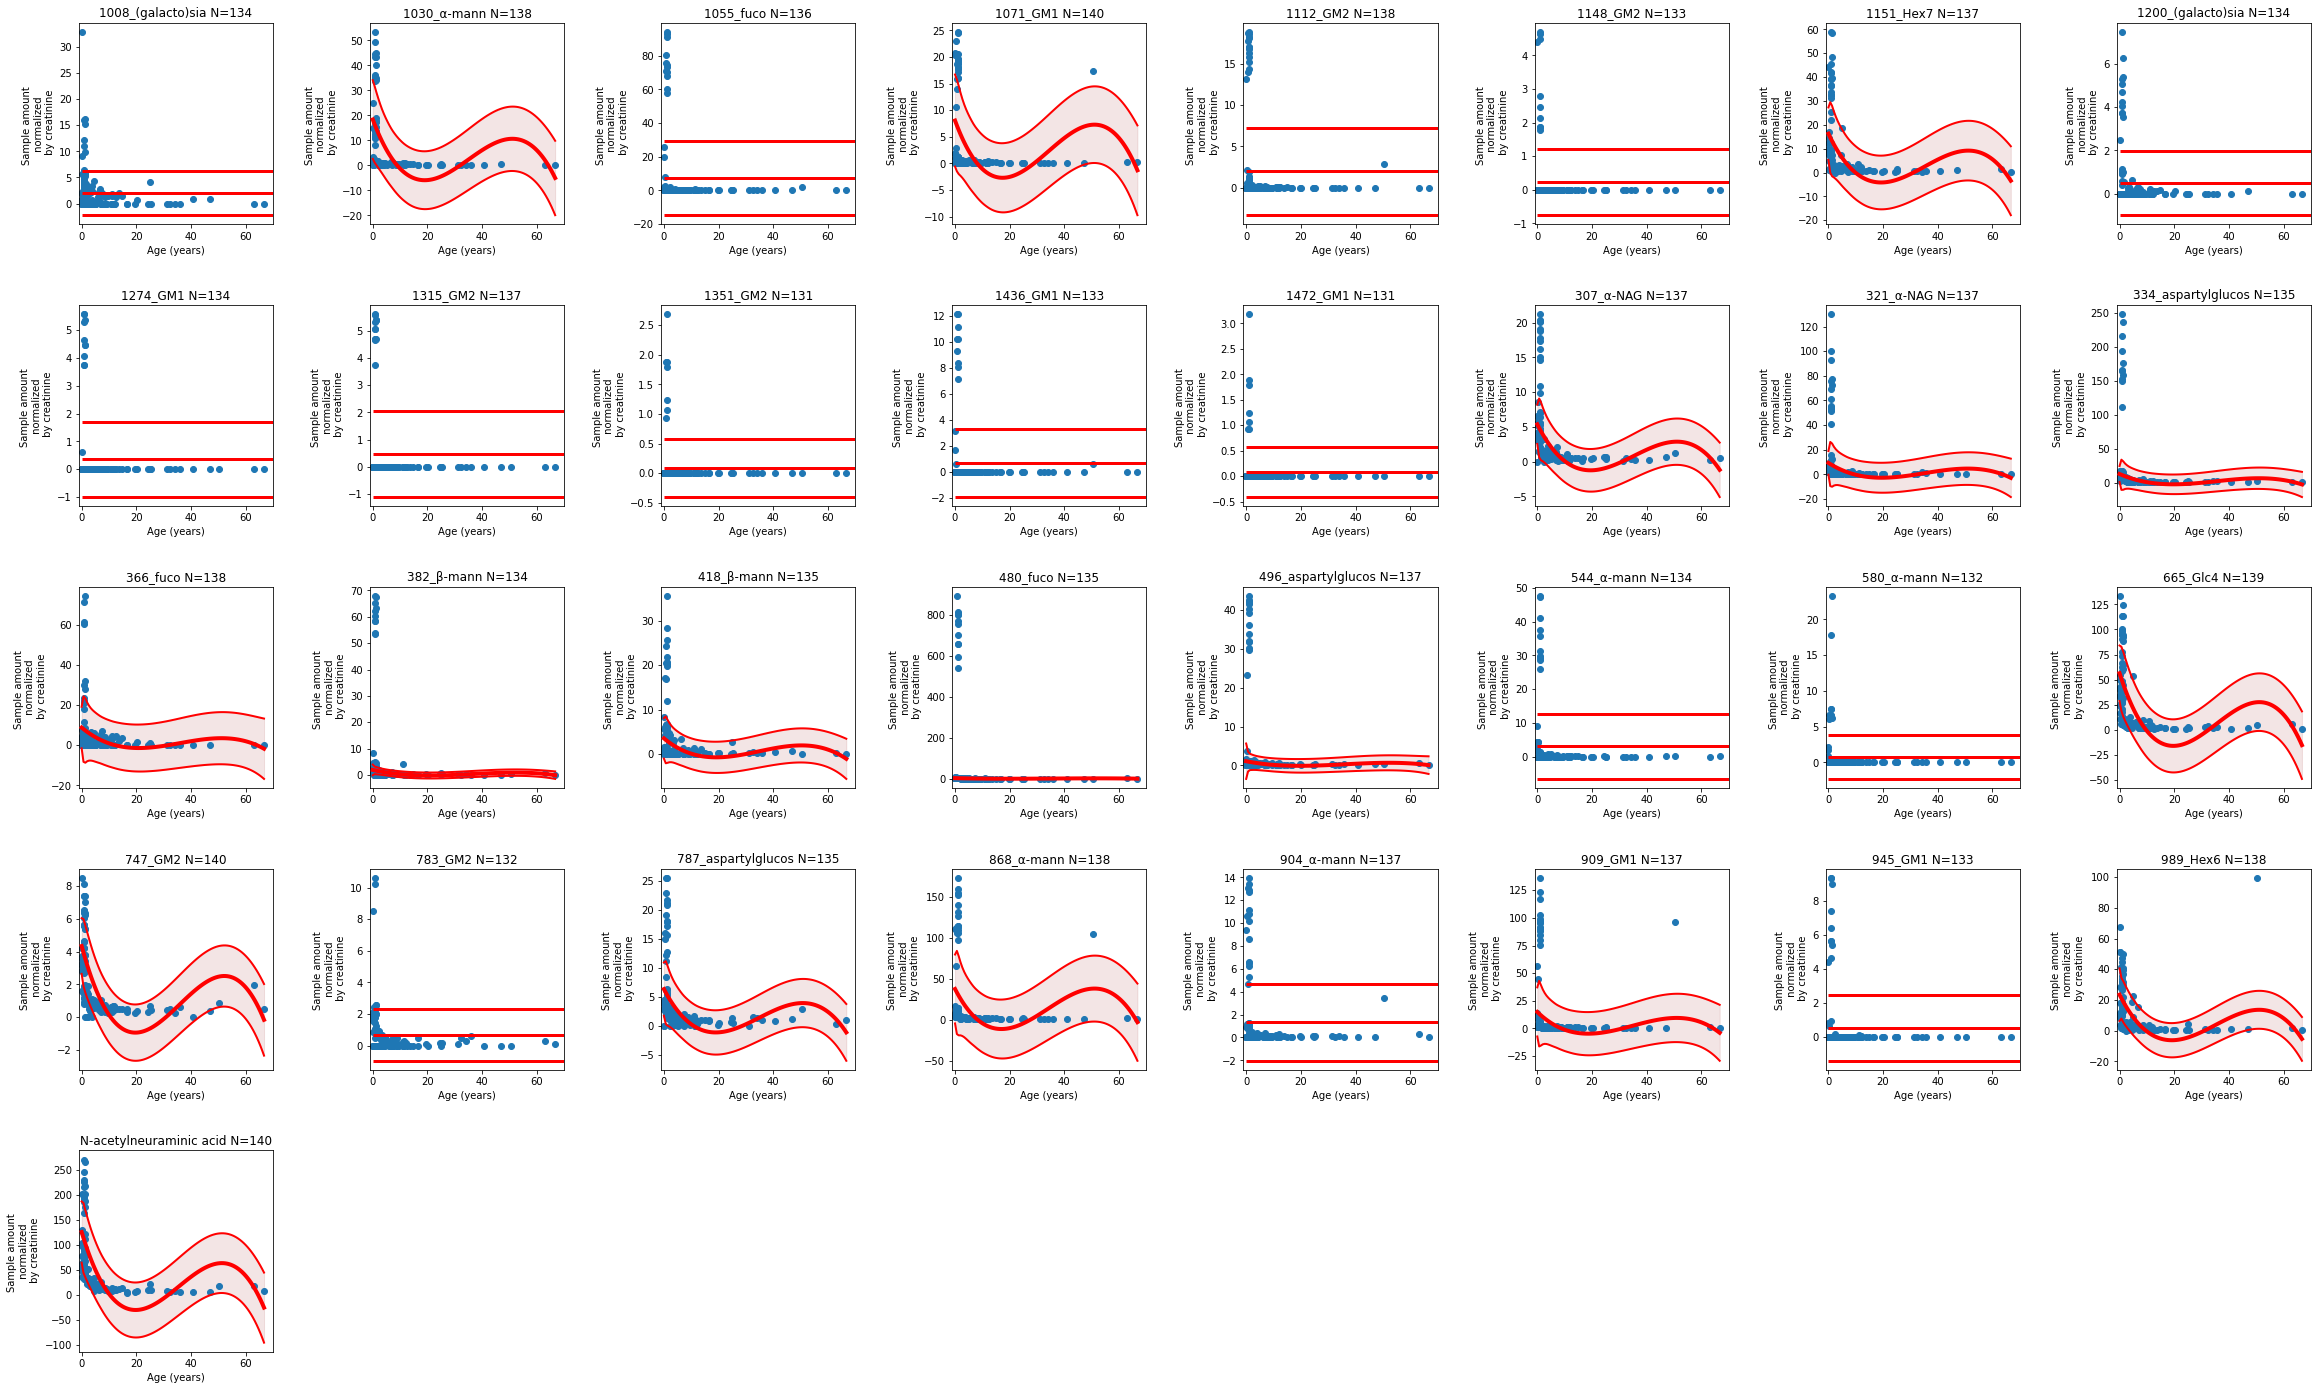

In [6]:
OP.determine_reference_values(plot = True)

## Determine Z-scores

In [7]:
data_batch = OP.determine_Z_scores(data_batch)

In [8]:
data_batch.head()

,Unnamed: 0,compound,sample_amt,peak_area,creatinine_mmol_liter,age_in_years,sample_ID,sample_amt_normalized,reference_values,Z_scores
0,0,1008_(galacto)sia,111.0,2306296.0,1.11622,1.14825,OLIGO01_01a,99.442762,"(2.0, 4.22, fixed)",23.091247
1,1,1030_α-mann,45.0,989866.0,1.11622,1.14825,OLIGO01_01a,40.314633,"(15.14, 14.72, LR)",1.709752
2,2,1055_fuco,0.0,5022.0,1.11622,1.14825,OLIGO01_01a,0.000000,"(7.2, 21.99, fixed)",-0.327303
3,3,1071_GM1,20.0,450356.0,1.11622,1.14825,OLIGO01_01a,17.917615,"(6.53, 8.43, LR)",1.351330
4,4,1112_GM2,19.0,429023.0,1.11622,1.14825,OLIGO01_01a,17.021734,"(1.99, 5.29, fixed)",2.840878


## Plots Z-scores

## Z-score plot for positive control (OLIGO01)

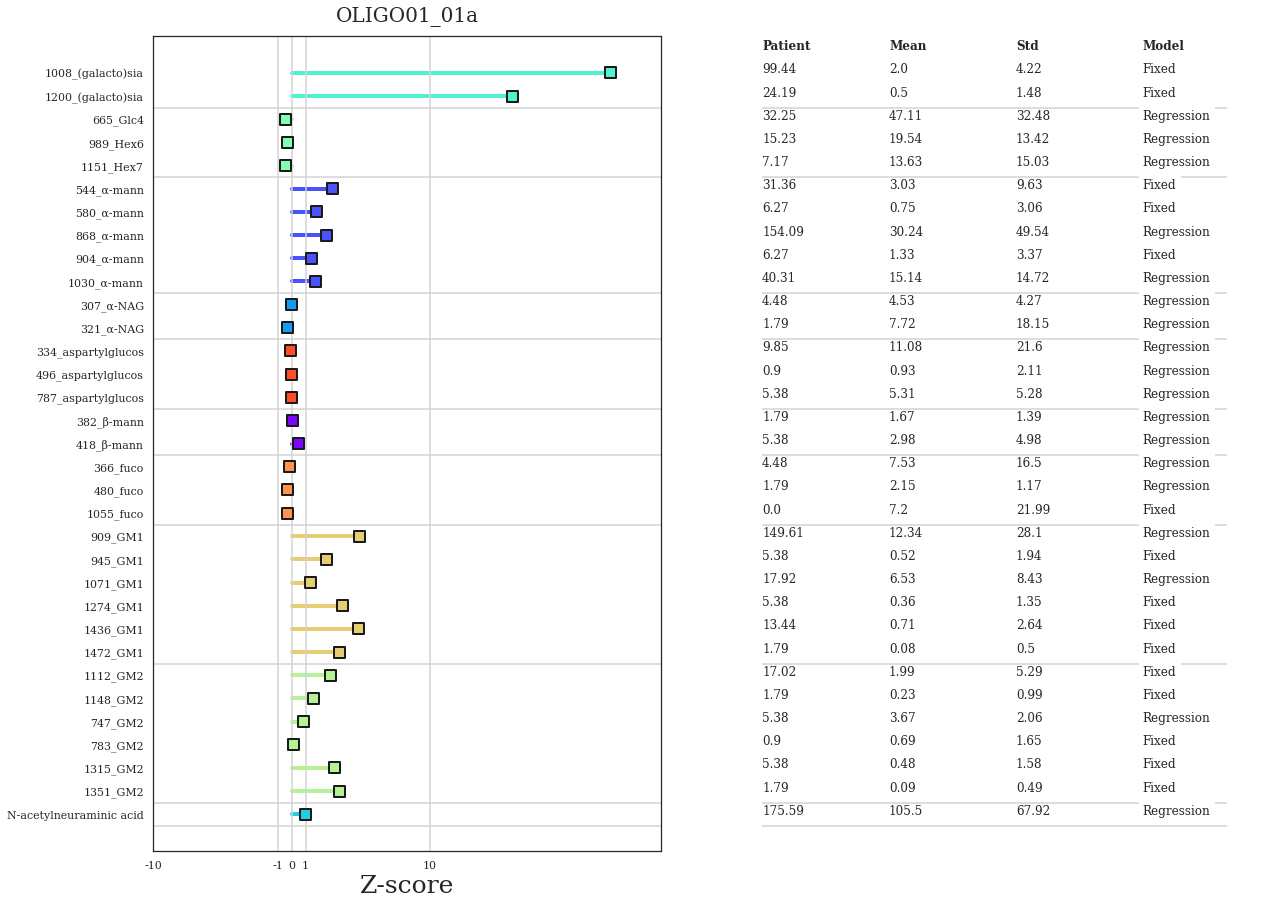

In [9]:
fig = OP.plot_Z_scores_patient(data_batch, 'OLIGO01_01a')

## Z-score plot for positive control (OLIGO02)

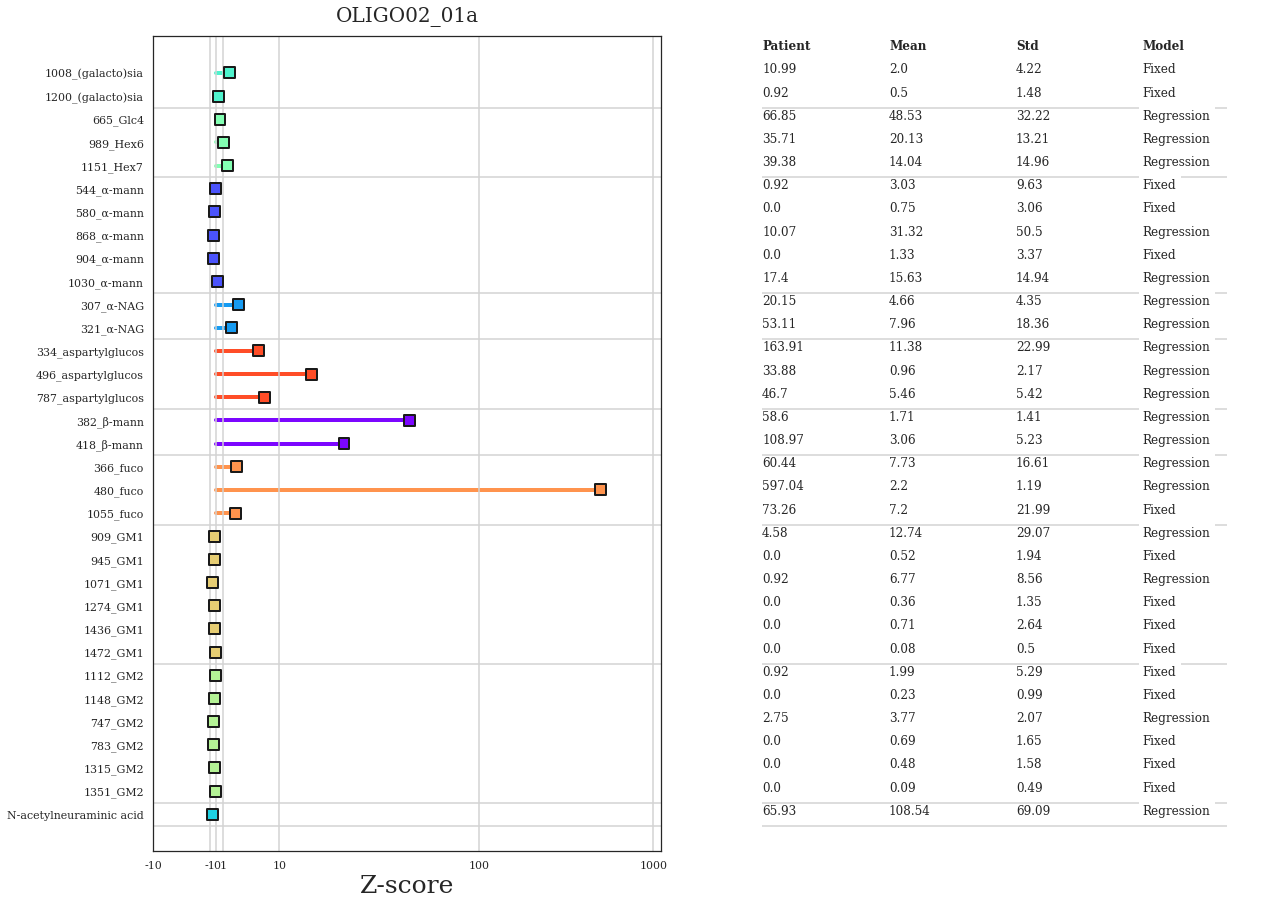

In [10]:
fig = OP.plot_Z_scores_patient(data_batch, 'OLIGO02_01a')

# QC on positive samples

Note, that number for this example pipeline are not the origina values.

In [11]:
data_oligo = all_data.loc[ all_data['sample_ID'].str.contains('OLIGO') ]
data_oligo = OP.determine_Z_scores(data_oligo)
data_oligo = data_oligo.assign(oligo_type = data_oligo['sample_ID'].apply( lambda x: 'OLIGO01' if 'OLIGO01' in x else 'OLIGO02') )

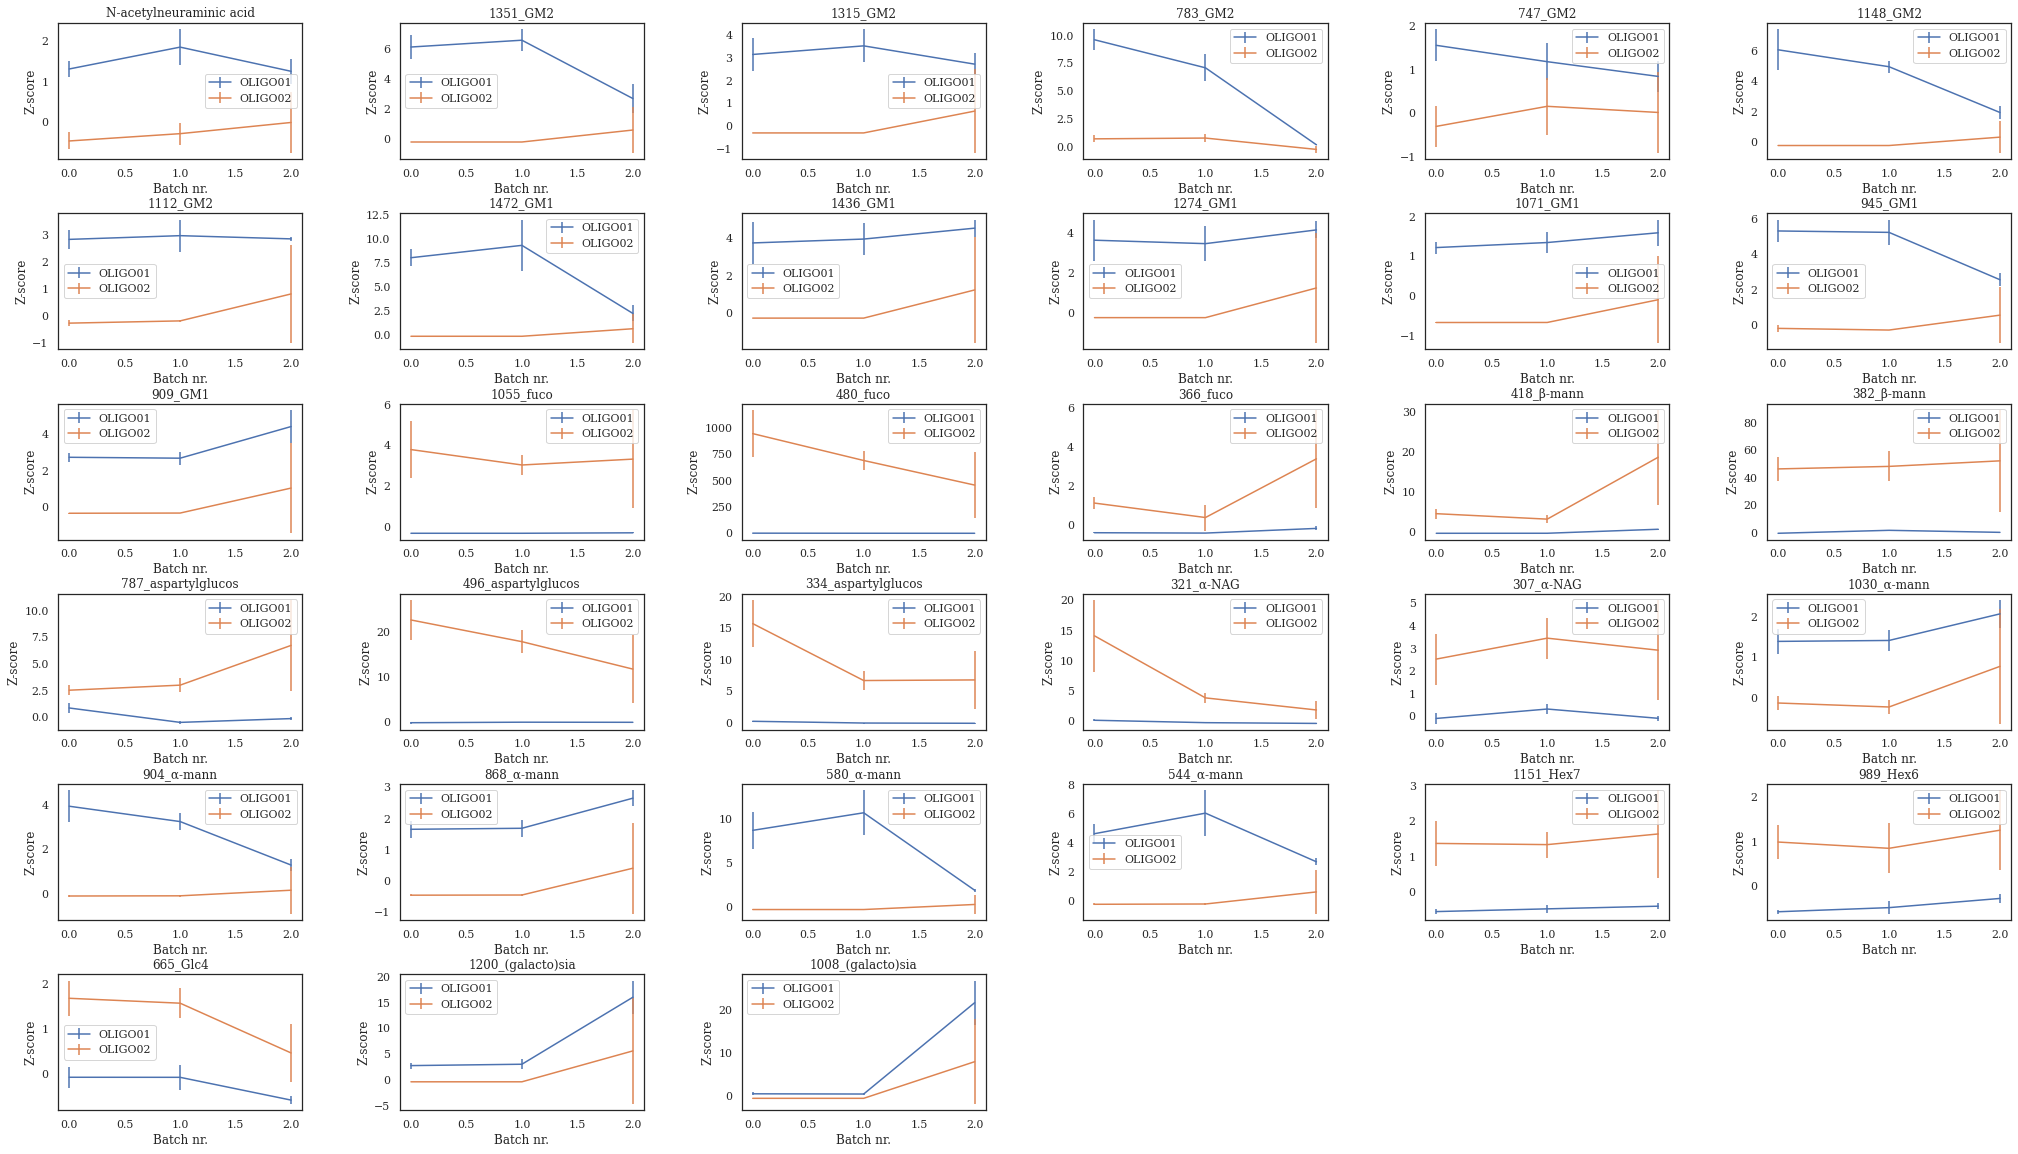

In [12]:
sns.set(font_scale=1,style='white', rc = {'font.family' : 'serif'})
fig = plt.figure(figsize=(35,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i,compound in enumerate( OligoPipeline.compound_disease_sorted ):
    ax = fig.add_subplot(6,6,1+i)

    df = data_oligo.loc[ data_oligo['compound'] == compound]
    batch_names = sorted(df['batch_name'].unique())

    for gb, data_gb in df.groupby('oligo_type'):

        x = list(range( len(batch_names) ))
        mean = data_gb.groupby('batch_name')['Z_scores'].mean().loc[batch_names]
        std = data_gb.groupby('batch_name')['Z_scores'].std().loc[batch_names]

        ax.errorbar(x,mean,label = gb, yerr = std)

    ax.legend()
    ax.set_title(compound)
    ax.set_xlabel('Batch nr.')
    ax.set_ylabel('Z-score')

# QC on internal standards

Note, that number for this example pipeline are not original values

In [13]:
data_IS = all_data.loc[ all_data['compound'].isin(OligoPipeline.internal_standards) ]

In [14]:
QC_df = []
for compound, data_compound in data_IS.groupby('compound'):
    
    for batch, data_compound_batch in data_compound.groupby('batch_name'):
        mean = data_compound_batch['peak_area'].mean()
        std = data_compound_batch['peak_area'].std()
        CV = std / abs(mean) *100
        QC_df.append([compound, batch, CV, mean, std])

In [15]:
QC_df = pd.DataFrame(QC_df, columns = ['compound', 'batch_name', 'CV', 'mean', 'std'])

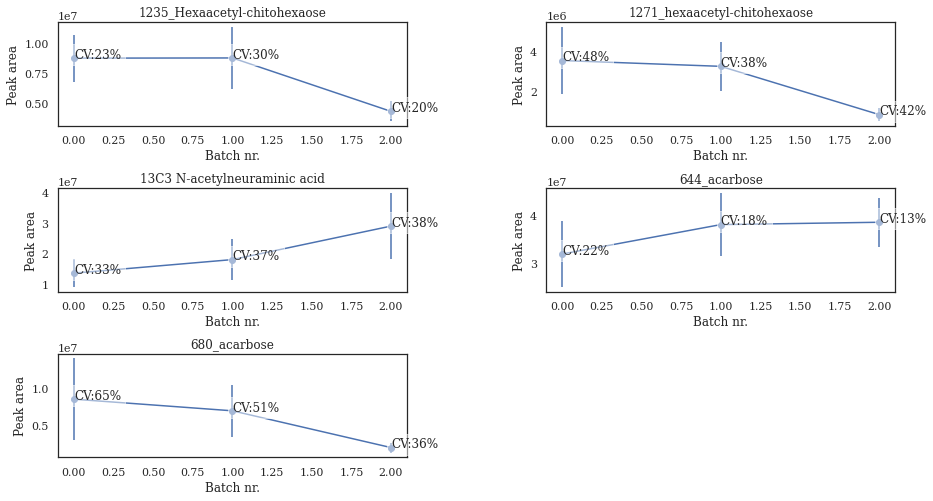

In [16]:
sns.set(font_scale=1,style='white', rc = {'font.family' : 'serif'})
fig = plt.figure(figsize=(15,8))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i,compound in enumerate( data_IS['compound'].unique() ):
    ax = fig.add_subplot(3,2,1+i)

    df = QC_df.loc[ QC_df['compound'] == compound].set_index('batch_name')
    batch_names = sorted(df.index.unique())
    batches = list(range( len(batch_names) ))
    
    mean = df.loc[batch_names,'mean']
    std =  df.loc[batch_names,'std']
    CV =  df.loc[batch_names,'CV']

    ax.errorbar(batches, mean, yerr = std, fmt='o-')
    
    for a,b,c in zip(batches, mean, CV):
        ax.text(a,b, 'CV:{}%'.format(round(c)),bbox=dict(facecolor='w', alpha=0.5))

    ax.set_title(compound)
    ax.set_xlabel('Batch nr.')
    ax.set_ylabel('Peak area')